<a href="https://colab.research.google.com/github/springboardmentor5432x/DV---Optimizing-IT-Support-Team-Performance-Using-Analytics-Supportlytics-/blob/Gokul-Optimizing-IT-Support-Team-Performance-Using-Analytics-(-Supportlytics)/milestone_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Milestone 1: Week 1-2**

 Module 1:- Project Initialization and Dataset Setup

In [38]:
import pandas as pd
import numpy as np

In [39]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('Supportlytics.csv')
df.head()

,Ticket_ID,Status,Priority,Source,Topic,Category,Agent_Group,Created_time,Expected_SLA_resolve,Resolution_Duration,SLA_Status,Survey_Results,Country,Latitude,Longitude,Agent_interactions
0,TIC-5000,Closed,Critical,Chat,Access Revoked,Security,Network Ops,25-11-2025 07:14,4,2.84,On-Time,3.0,Germany,51.16,10.45,6
1,TIC-5001,Closed,Medium,Email,Wi-Fi Access,Network,Infrastructure,19-07-2025 11:09,24,27.19,Breached,4.0,Germany,51.16,10.45,8
2,TIC-5002,Resolved,Critical,Chat,Printer,Hardware,L2 Technical Support,01-05-2025 22:29,4,2.96,On-Time,NaN,India,20.59,78.96,2
3,TIC-5003,Closed,High,Email,Bug Report,Software,Security Admin,19-06-2025 07:21,8,1.89,On-Time,2.0,UK,55.37,-3.43,8
4,TIC-5004,Closed,Low,Chat,Update Failure,Software,L1 Service Desk,17-01-2025 06:30,48,10.85,On-Time,2.0,Brazil,-14.23,-51.92,3


In [40]:
df['Created_time'] = pd.to_datetime(df['Created_time'], dayfirst=True)

class DataProfiler:
    def __init__(self, data):
        self.data = data

    def health_check(self):
        profile = pd.DataFrame({
            'Data Type': self.data.dtypes,
            'Missing Values': self.data.isnull().sum(),
            'Unique Values': self.data.nunique(),
            'Completeness (%)': (1 - self.data.isnull().sum() / len(self.data)) * 100
        })
        return profile

# Execute Health Check
profiler = DataProfiler(df)
print("\n--- Advanced Data Health Report ---")
display(profiler.health_check())


--- Advanced Data Health Report ---


,Data Type,Missing Values,Unique Values,Completeness (%)
Ticket_ID,object,0,5000,100.00
Status,object,0,3,100.00
Priority,object,0,4,100.00
Source,object,0,4,100.00
Topic,object,0,16,100.00
Category,object,0,4,100.00
Agent_Group,object,0,5,100.00
Created_time,datetime64[ns],0,4974,100.00
Expected_SLA_resolve,int64,0,4,100.00
Resolution_Duration,float64,236,3109,95.28


In [41]:
# 1. Flagging original missing values (Requirement for Milestone 1)
df['Resolution_Imputed'] = df['Resolution_Duration'].isnull().astype(int)
df['Survey_Imputed'] = df['Survey_Results'].isnull().astype(int)

# 2. Advanced Imputation for Resolution Duration
# Only impute for Closed/Resolved tickets to avoid skewing 'Open' ticket metrics
mask = (df['Status'].isin(['Closed', 'Resolved'])) & (df['Resolution_Duration'].isnull())
df.loc[mask, 'Resolution_Duration'] = df[mask].groupby(['Category', 'Priority'])['Resolution_Duration'].transform(
    lambda x: x.fillna(x.median() if not np.isnan(x.median()) else df['Resolution_Duration'].median())
)

# 3. Neutral Imputation for Survey Results
avg_sat = df['Survey_Results'].mean()
df['Survey_Results'] = df['Survey_Results'].fillna(avg_sat)

print("\n[Data Cleaning Complete]: Missing values handled using Grouped Median and Global Mean logic.")

# Metric Definitions & Distributions

# Metric A: Resolution Gap (Expected vs Actual)
df['Resolution_Gap'] = df['Expected_SLA_resolve'] - df['Resolution_Duration']

# Metric B: Response Efficiency (Expected SLA / Interactions)
df['Response_Efficiency'] = df['Expected_SLA_resolve'] / (df['Agent_interactions'] + 1)

# Metric C: Initial Distribution Analysis
print("\n--- Ticket Distribution: Priority ---")
display(df['Priority'].value_counts().to_frame())

print("\n--- Multi-Factor Distribution: Category x Priority ---")
dist_matrix = pd.crosstab(df['Category'], df['Priority'], margins=True, margins_name="Total")
display(dist_matrix)


[Data Cleaning Complete]: Missing values handled using Grouped Median and Global Mean logic.

--- Ticket Distribution: Priority ---


,count
Priority,
Medium,2003
Low,1528
High,975
Critical,494



--- Multi-Factor Distribution: Category x Priority ---


Priority,Critical,High,Low,Medium,Total
Category,,,,,
Hardware,116,255,412,515,1298
Network,126,236,406,487,1255
Security,121,246,343,485,1195
Software,131,238,367,516,1252
Total,494,975,1528,2003,5000


**Module** 2: Similarity Level & Performance Bucketing

In [42]:


# 1. Normalize the metrics to a 0-1 scale for comparison
# Speed Score: 1 is best (instant), 0 is worst (slow)
df['Normalized_Speed'] = 1 - (df['Resolution_Duration'] / df['Expected_SLA_resolve'].replace(0, 1))
# Satisfaction Score: 1 is best (5/5), 0 is worst (1/5)
df['Normalized_Satisfaction'] = (df['Survey_Results'] - 1) / 4

# 2. Define the Similarity_Level (Weighted Average)
# We give 60% weight to SLA Speed and 40% to Customer Satisfaction
df['Similarity_Score'] = (df['Normalized_Speed'] * 0.6) + (df['Normalized_Satisfaction'] * 0.4)

# Handle cases where Speed might be negative (massive SLA breach)
df['Similarity_Score'] = df['Similarity_Score'].clip(lower=0, upper=1)

print("Similarity Scores calculated based on Speed and Satisfaction.")

Similarity Scores calculated based on Speed and Satisfaction.


*  Categorizing Similarity_Level into performance buckets

In [43]:

def get_performance_bucket(score):
    if pd.isna(score): return "Pending"
    if score >= 0.75: return "High Performer"
    if score >= 0.40: return "Standard"
    return "Low Efficiency"

df['Performance_Bucket'] = df['Similarity_Score'].apply(get_performance_bucket)

# 4. Final Review of the Buckets
bucket_dist = df['Performance_Bucket'].value_counts()
print("\n--- Performance Bucket Distribution ---")
print(bucket_dist)


--- Performance Bucket Distribution ---
Performance_Bucket
Low Efficiency    3022
Standard          1481
High Performer     261
Pending            236
Name: count, dtype: int64


In [44]:
df.rename(columns={'Topic': 'Queue'}, inplace=True)
df.head()

,Ticket_ID,Status,Priority,Source,Queue,Category,Agent_Group,Created_time,Expected_SLA_resolve,Resolution_Duration,...,Longitude,Agent_interactions,Resolution_Imputed,Survey_Imputed,Resolution_Gap,Response_Efficiency,Normalized_Speed,Normalized_Satisfaction,Similarity_Score,Performance_Bucket
0,TIC-5000,Closed,Critical,Chat,Access Revoked,Security,Network Ops,2025-11-25 07:14:00,4,2.84,...,10.45,6,0,0,1.16,0.571429,0.290000,0.500000,0.374000,Low Efficiency
1,TIC-5001,Closed,Medium,Email,Wi-Fi Access,Network,Infrastructure,2025-07-19 11:09:00,24,27.19,...,10.45,8,0,0,-3.19,2.666667,-0.132917,0.750000,0.220250,Low Efficiency
2,TIC-5002,Resolved,Critical,Chat,Printer,Hardware,L2 Technical Support,2025-05-01 22:29:00,4,2.96,...,78.96,2,0,1,1.04,1.333333,0.260000,0.505661,0.358264,Low Efficiency
3,TIC-5003,Closed,High,Email,Bug Report,Software,Security Admin,2025-06-19 07:21:00,8,1.89,...,-3.43,8,0,0,6.11,0.888889,0.763750,0.250000,0.558250,Standard
4,TIC-5004,Closed,Low,Chat,Update Failure,Software,L1 Service Desk,2025-01-17 06:30:00,48,10.85,...,-51.92,3,0,0,37.15,12.000000,0.773958,0.250000,0.564375,Standard


In [45]:
df.to_csv('cleaned_Supportlytics.csv', index=False)

**Milestone 2: Week 3-4**

module-3

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (8,5)
sns.set_style("whitegrid")

In [47]:
df = pd.read_csv('/content/cleaned_Supportlytics.csv')
df.head()


,Ticket_ID,Status,Priority,Source,Queue,Category,Agent_Group,Created_time,Expected_SLA_resolve,Resolution_Duration,...,Longitude,Agent_interactions,Resolution_Imputed,Survey_Imputed,Resolution_Gap,Response_Efficiency,Normalized_Speed,Normalized_Satisfaction,Similarity_Score,Performance_Bucket
0,TIC-5000,Closed,Critical,Chat,Access Revoked,Security,Network Ops,2025-11-25 07:14:00,4,2.84,...,10.45,6,0,0,1.16,0.571429,0.290000,0.500000,0.374000,Low Efficiency
1,TIC-5001,Closed,Medium,Email,Wi-Fi Access,Network,Infrastructure,2025-07-19 11:09:00,24,27.19,...,10.45,8,0,0,-3.19,2.666667,-0.132917,0.750000,0.220250,Low Efficiency
2,TIC-5002,Resolved,Critical,Chat,Printer,Hardware,L2 Technical Support,2025-05-01 22:29:00,4,2.96,...,78.96,2,0,1,1.04,1.333333,0.260000,0.505661,0.358264,Low Efficiency
3,TIC-5003,Closed,High,Email,Bug Report,Software,Security Admin,2025-06-19 07:21:00,8,1.89,...,-3.43,8,0,0,6.11,0.888889,0.763750,0.250000,0.558250,Standard
4,TIC-5004,Closed,Low,Chat,Update Failure,Software,L1 Service Desk,2025-01-17 06:30:00,48,10.85,...,-51.92,3,0,0,37.15,12.000000,0.773958,0.250000,0.564375,Standard


In [48]:
print("--- Performance Bucket Distribution ---")
display(df['Performance_Bucket'].value_counts().to_frame())

--- Performance Bucket Distribution ---


,count
Performance_Bucket,
Low Efficiency,3022
Standard,1481
High Performer,261
Pending,236


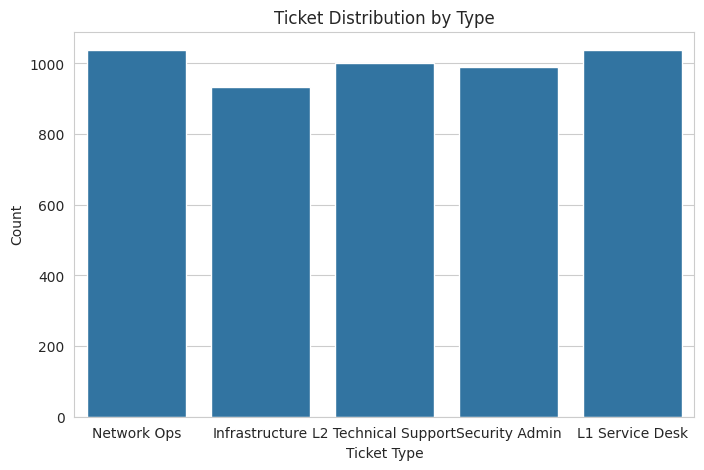

In [49]:
sns.countplot(data=df, x='Agent_Group')
plt.title('Ticket Distribution by Type')
plt.xlabel('Ticket Type')
plt.ylabel('Count')
plt.show()

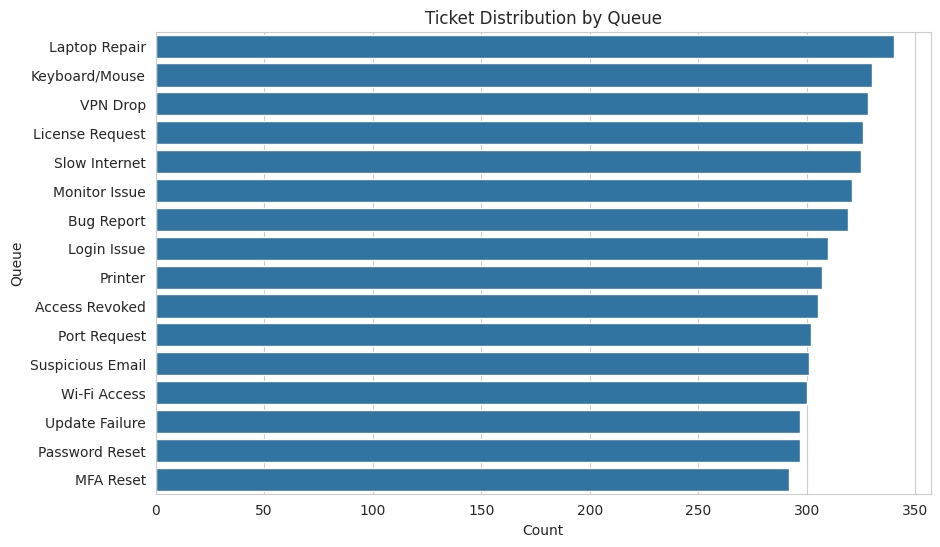

In [50]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='Queue', order=df['Queue'].value_counts().index)
plt.title('Ticket Distribution by Queue')
plt.xlabel('Count')
plt.ylabel('Queue')
plt.show()

In [51]:
print("--- Top Categories by Frequency ---")
display(df['Category'].value_counts().to_frame())

--- Top Categories by Frequency ---


,count
Category,
Hardware,1298
Network,1255
Software,1252
Security,1195


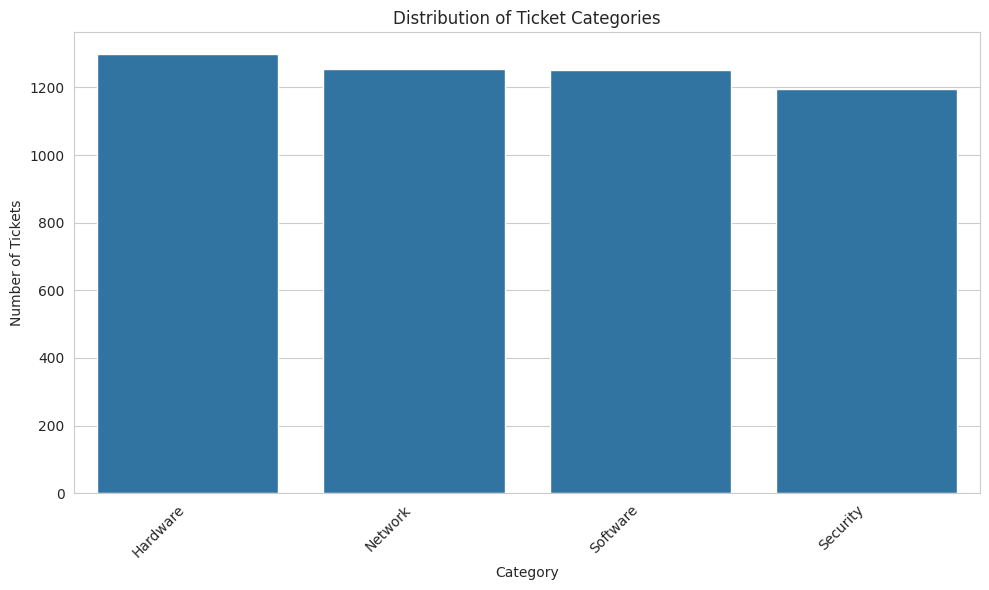

In [52]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df['Category'].value_counts().index, y=df['Category'].value_counts().values)
plt.title('Distribution of Ticket Categories')
plt.xlabel('Category')
plt.ylabel('Number of Tickets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

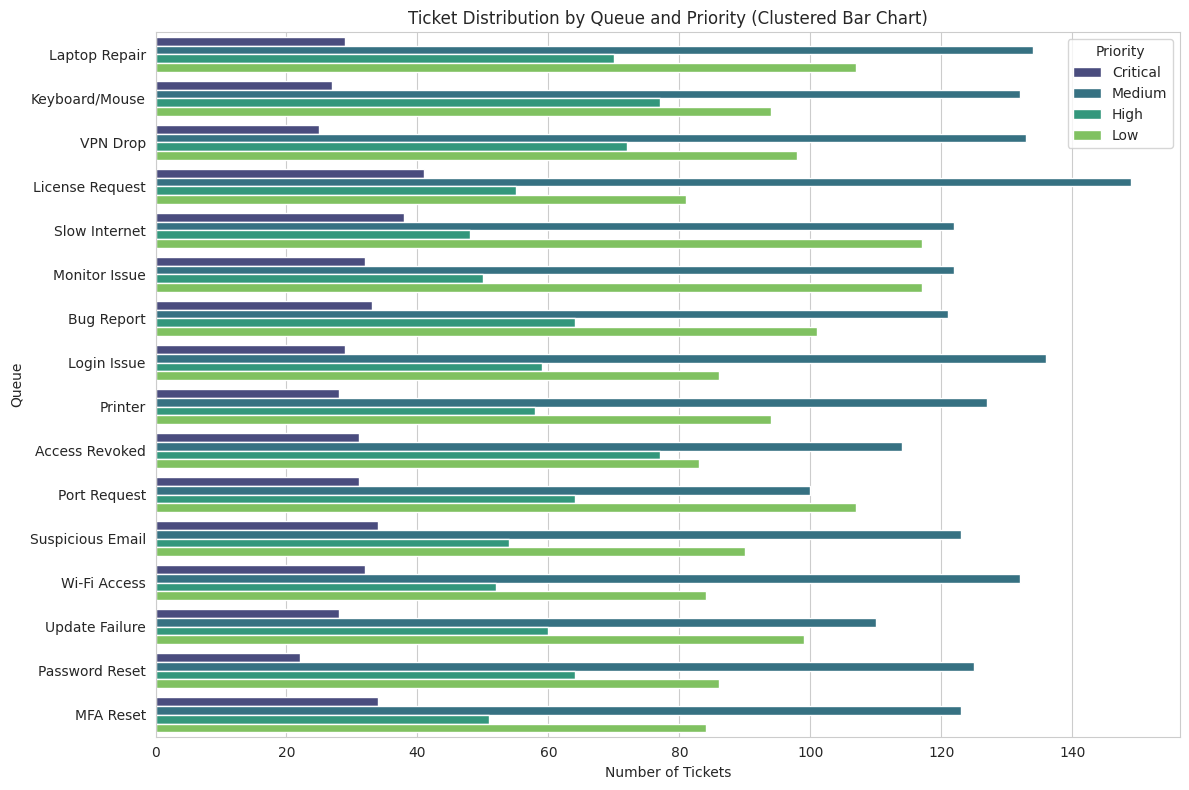

In [53]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df, y='Queue', hue='Priority', order=df['Queue'].value_counts().index, palette='viridis')
plt.title('Ticket Distribution by Queue and Priority (Clustered Bar Chart)')
plt.xlabel('Number of Tickets')
plt.ylabel('Queue')
plt.legend(title='Priority')
plt.tight_layout()
plt.show()

module-4 Similarity  and cluster insight

Select numerical features for clustering

In [54]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
features = [
    'Resolution_Duration',
    'Expected_SLA_resolve',
    'Agent_interactions',
    'Normalized_Speed',
    'Normalized_Satisfaction',
    'Similarity_Score'
]

Handle potential NaN values in selected features before scaling

In [55]:
df_clustering = df[features].dropna()

Scale the features

In [56]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering)

print("Features selected and scaled for clustering.")

Features selected and scaled for clustering.


In [57]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10) # n_init added for best practices

# Predict clusters only for the rows that were used for clustering (i.e., not dropped NaN rows)
df.loc[df_clustering.index, 'Cluster_ID'] = kmeans.fit_predict(X_scaled)

print("K-Means clustering performed successfully, 'Cluster_ID' created.")

K-Means clustering performed successfully, 'Cluster_ID' created.


In [58]:
print("--- Cluster Characteristics (Mean Values) ---")
display(df.groupby('Cluster_ID')[features].mean())

--- Cluster Characteristics (Mean Values) ---


,Resolution_Duration,Expected_SLA_resolve,Agent_interactions,Normalized_Speed,Normalized_Satisfaction,Similarity_Score
Cluster_ID,,,,,,
0.0,20.615010,16.637407,4.238352,-0.238135,0.441867,0.100403
1.0,9.908706,20.917431,7.475229,0.483323,0.291960,0.406902
2.0,54.012490,48.000000,4.763598,-0.125260,0.471767,0.163839
3.0,12.369992,25.539208,4.836702,0.490890,0.796537,0.613149


In [59]:
df[['Cluster_ID','Similarity_Score', 'Resolution_Duration' ]].head()

,Cluster_ID,Similarity_Score,Resolution_Duration
0,1.0,0.374000,2.84
1,0.0,0.220250,27.19
2,0.0,0.358264,2.96
3,1.0,0.558250,1.89
4,3.0,0.564375,10.85


In [60]:
cluster_similarity = (
    df.groupby('Cluster_ID')['Similarity_Score']
      .mean()
      .sort_values(ascending=False)
)

cluster_similarity

,Similarity_Score
Cluster_ID,
3.0,0.613149
1.0,0.406902
2.0,0.163839
0.0,0.100403


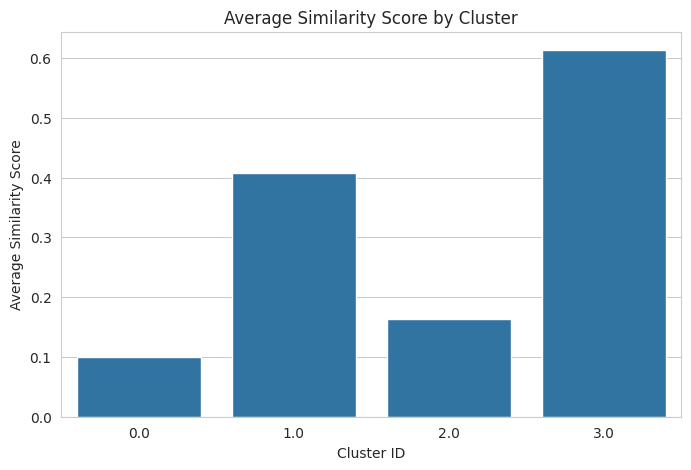

In [61]:
sns.barplot(x=cluster_similarity.index, y=cluster_similarity.values)
plt.title('Average Similarity Score by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Average Similarity Score')
plt.show()


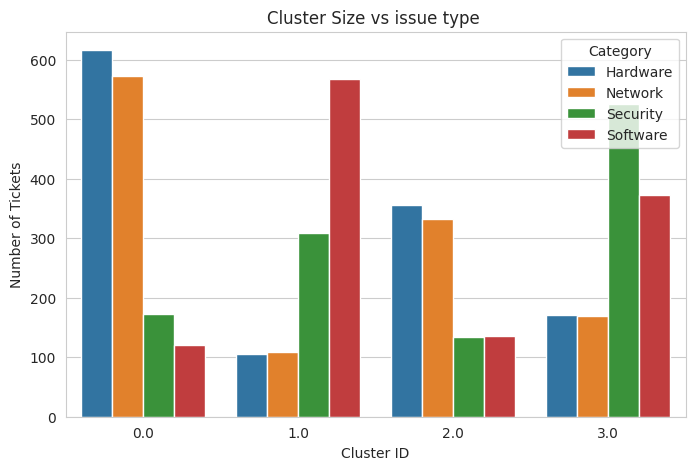

In [62]:

cluster_size = df.groupby(['Cluster_ID', 'Category']).size().reset_index(name='Count')

sns.barplot(data=cluster_size, x='Cluster_ID', y='Count', hue='Category')
plt.title('Cluster Size vs issue type ')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Tickets')
plt.show()

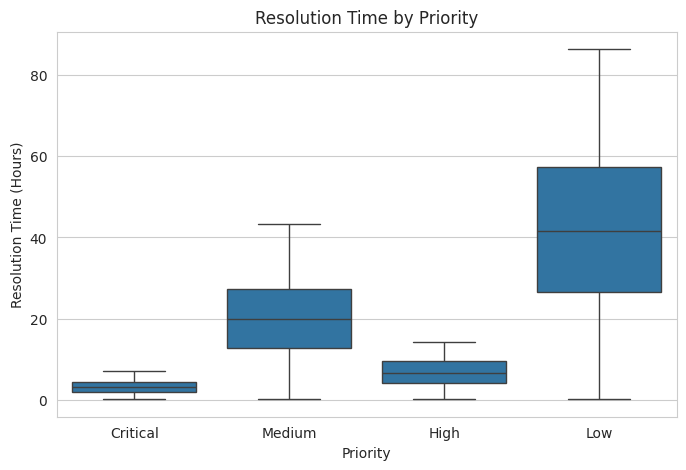

In [63]:
sns.boxplot(data=df, x='Priority', y='Resolution_Duration')
plt.title('Resolution Time by Priority')
plt.xlabel('Priority')
plt.ylabel('Resolution Time (Hours)')
plt.show()

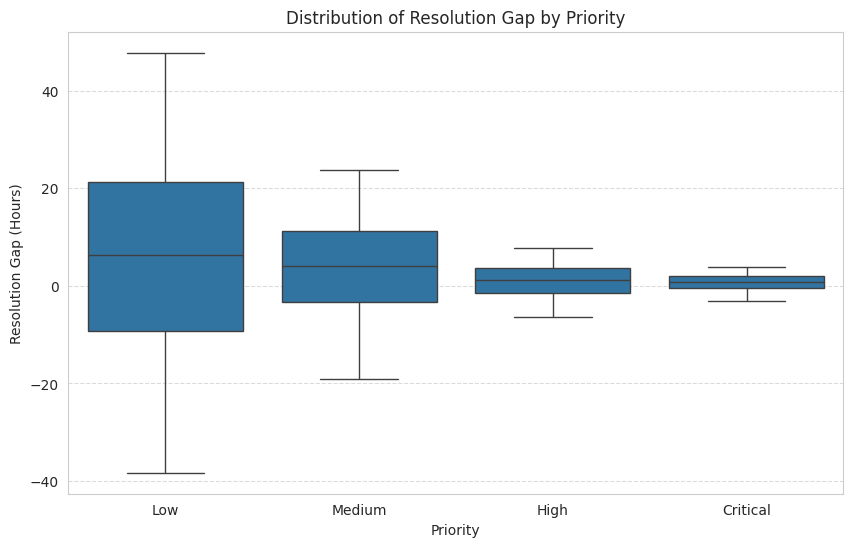

In [64]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Priority', y='Resolution_Gap', order=['Low', 'Medium', 'High', 'Critical'])
plt.title('Distribution of Resolution Gap by Priority')
plt.xlabel('Priority')
plt.ylabel('Resolution Gap (Hours)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()